# Surgical Dataset (Cholec 20) Processing and Annotation Exploration

This notebook loads surgical video metadata and frame annotations from AWS S3, explores the dataset structure, cleans annotation files, and prepares the data for future model training.


## Environment Setup

This section contains the required Python packages and dependencies used throughout the notebook.


In [1]:
# Importing all the required packages 
import boto3 
import pandas as pd
import numpy as np
import os 
import re
from PIL import Image
import io 
import matplotlib.pyplot as plt

## Connecting to AWS S3

Here we establish a connection with the AWS bucket and verify access by listing available files.


In [2]:
# Configuring the dataset bucket to access the data
s3 = boto3.client('s3')
bucket = 'surgimind01' # Note : later I need to update this with env


## Dataset Structure Overview

The dataset contains folders for training, testing, and validation. Each folder includes:
- PNG or video frames
- Corresponding annotation JSON files
- Category metadata (where applicable)

Lets inspect the structure to understand naming patterns and consistency.


In [3]:
def data_info(prefix):
    """
    Since the dataset is large (around 35 GB), S3 only returns up to 1000 keys per request. 
    To avoid missing files, a paginator is used to iterate through all pages and list every object matching the prefix. 
    This allows us to accurately count all frames, videos, or metadata stored under a given folder.
    S3 does NOT treat folders as objects. So the solution is: count unique prefixes.
"""
    paginator = s3.get_paginator("list_objects_v2")
    folders = set()
    for page in paginator.paginate(Bucket=bucket, Prefix=prefix, Delimiter="/"):
        for folder in page.get("CommonPrefixes", []):
            folders.add(folder["Prefix"])
    print("Total video folders:", len(folders))
    
data_info("Testing/")

Total video folders: 8


In [4]:
data_info("Training/")

Total video folders: 10


In [5]:
data_info("Validation/")

Total video folders: 2


## Dataset Summary

The dataset is split into three subsets representing different stages of the workflow.  
Each subset contains multiple folders, where each folder corresponds to a single surgical video.

| Split Type | Number of Videos | Contains MP4 | Contains Frames | Contains JSON |
| ---------- | ---------------- | ------------ | --------------- | ------------- |
| Training   | 10               | Yes          | Yes             | Yes           |
| Testing    | 8                | No           | Yes             | Yes           |
| Validation | 2                | No           | Yes             | Yes           |

## Loading Frames and Annotation Files

This step extracts image files and associated annotations. The goal is to map each frame with its corresponding metadata.


In [6]:
def load_frames(prefix, N=4):
    """
    Parameters:
    - prefix (str): S3 path pointing to a single video's Frames directory
    - N (int): Number of frames to preview from the start of the video

    Returns:
    - None (displays frames using matplotlib)
    """
    s3 = boto3.client("s3")

    keys = []
    paginator = s3.get_paginator("list_objects_v2")
    for page in paginator.paginate(Bucket=bucket, Prefix=prefix):
        for obj in page.get("Contents", []):
            if obj["Key"].lower().endswith(("png", "jpg", "jpeg")):
                keys.append(obj["Key"])

    if not keys:
        print(f"No frames found for {prefix}")
        return

    # sort numerically
    def extract_num(k):
        return int(re.findall(r"(\d+)", k)[-1])

    keys = sorted(keys, key=extract_num)[:N]

    images = []
    for key in keys:
        resp = s3.get_object(Bucket=bucket, Key=key)
        img = Image.open(io.BytesIO(resp["Body"].read())).resize((300, 300))
        images.append((key.split("/")[-1], img))

    cols = N
    plt.figure(figsize=(4 * cols, 4))
    for i, (name, img) in enumerate(images):
        ax = plt.subplot(1, cols, i + 1)
        ax.imshow(img)
        ax.set_title(name, fontsize=12)
        ax.axis("off")

    plt.suptitle(prefix.split("/")[-3], fontsize=16, fontweight="bold")
    plt.tight_layout()
    plt.show()


4 Frames per VID02


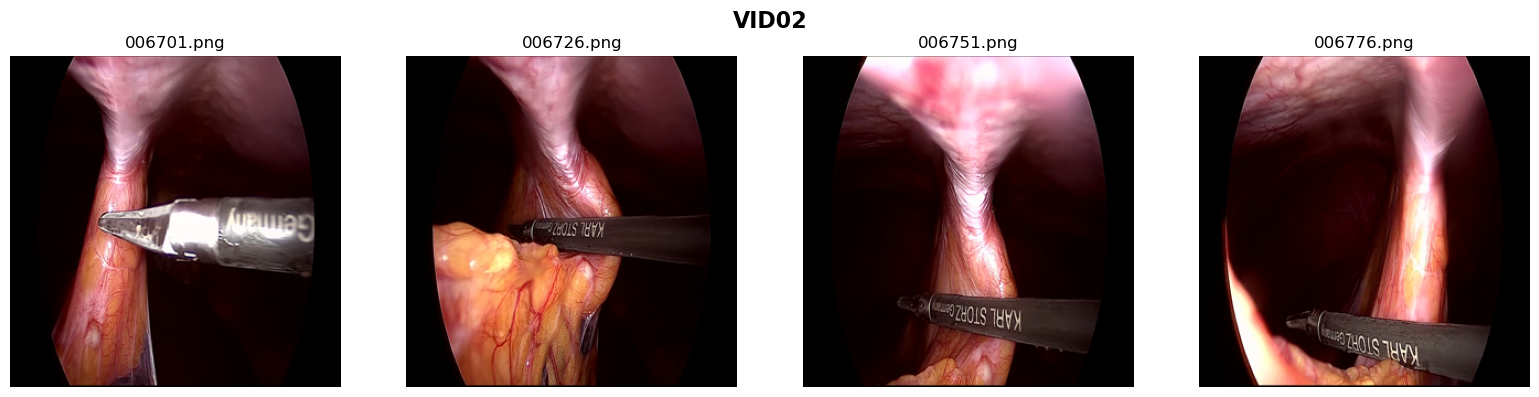

4 Frames per VID04


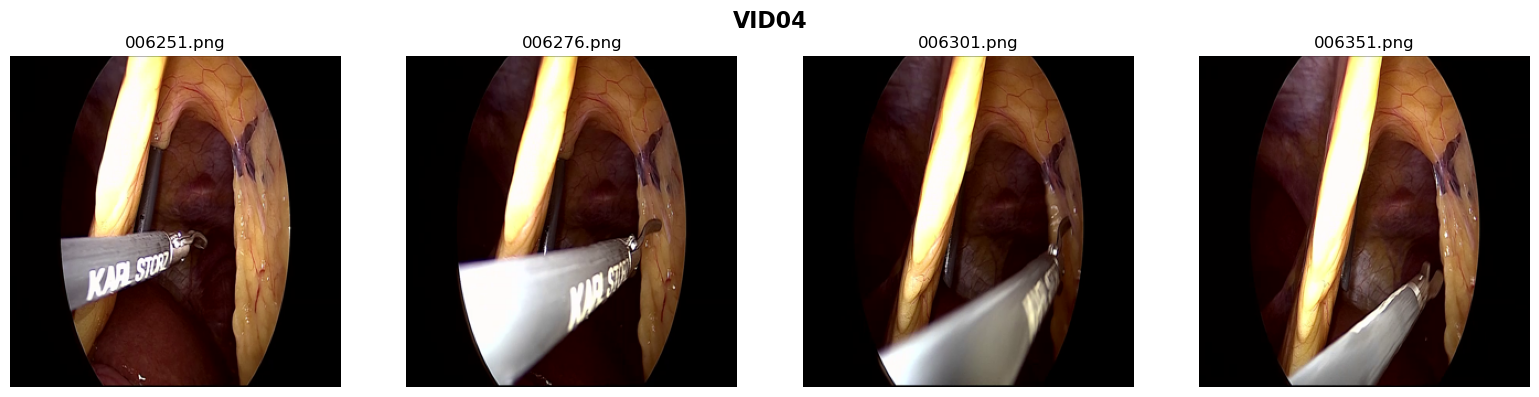

4 Frames per VID103


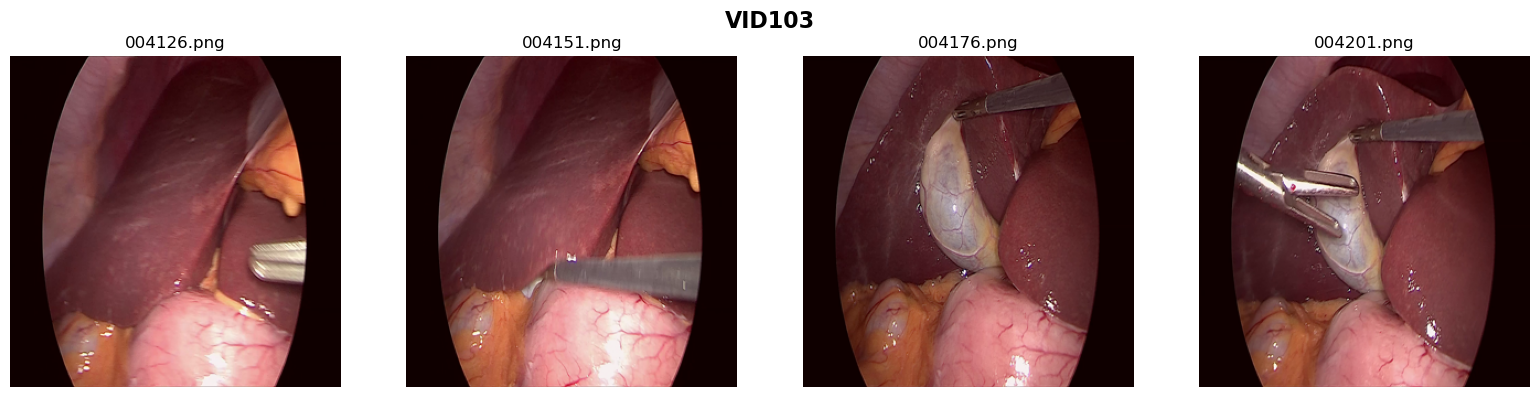

4 Frames per VID11


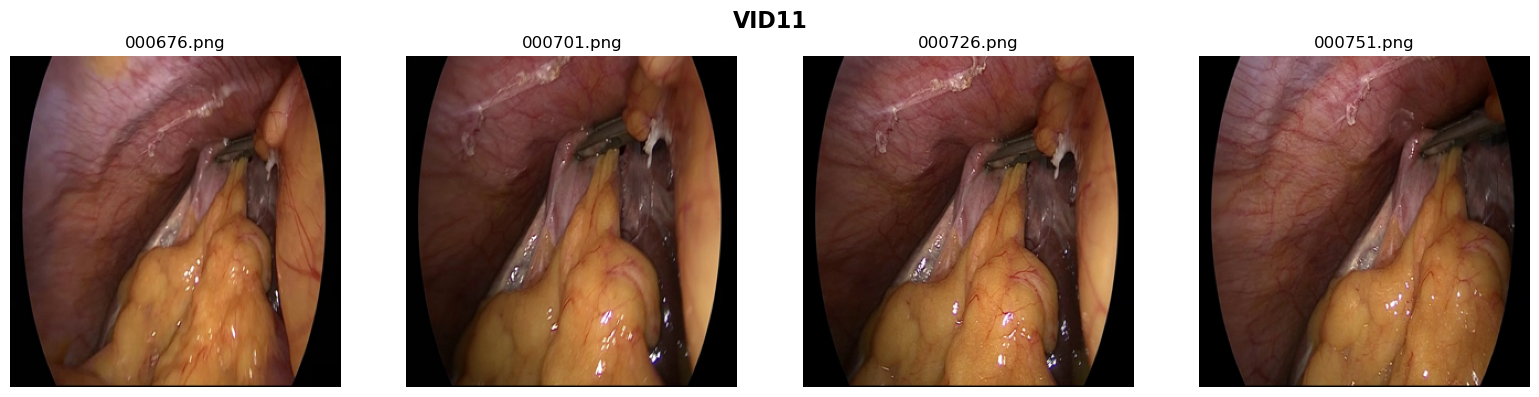

4 Frames per VID13


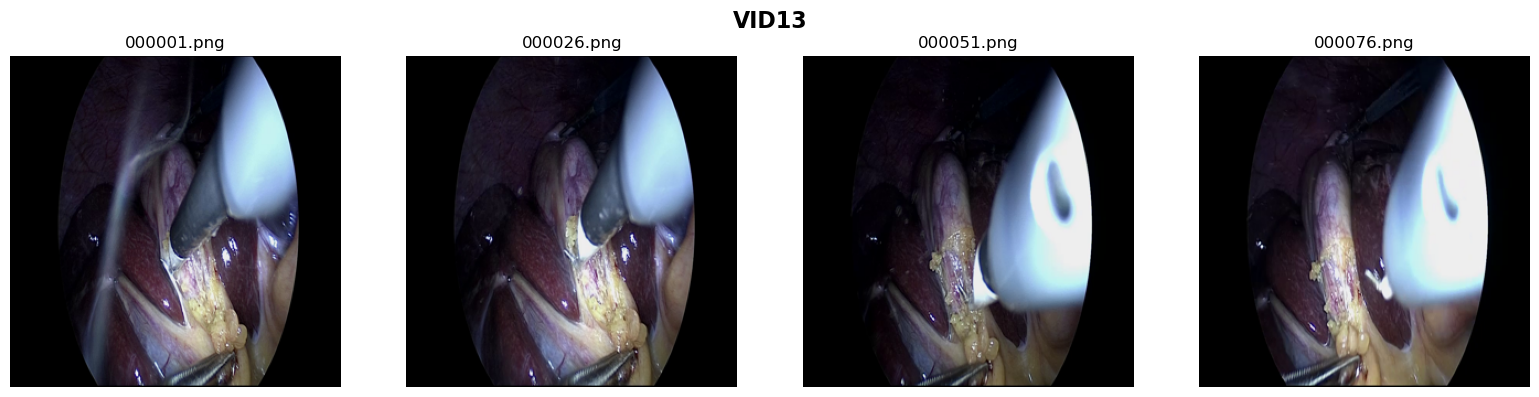

4 Frames per VID17


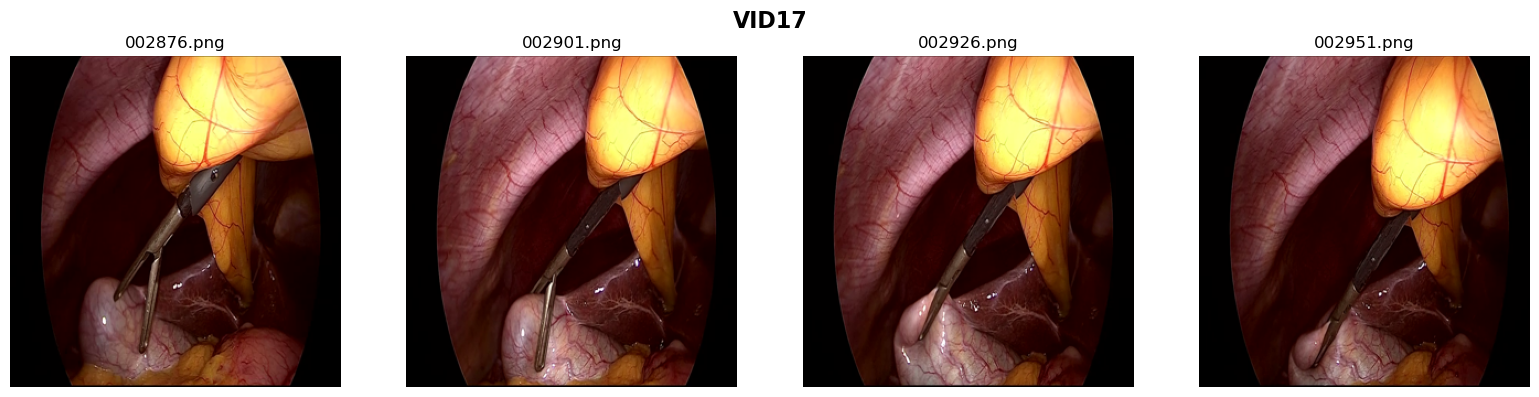

4 Frames per VID23


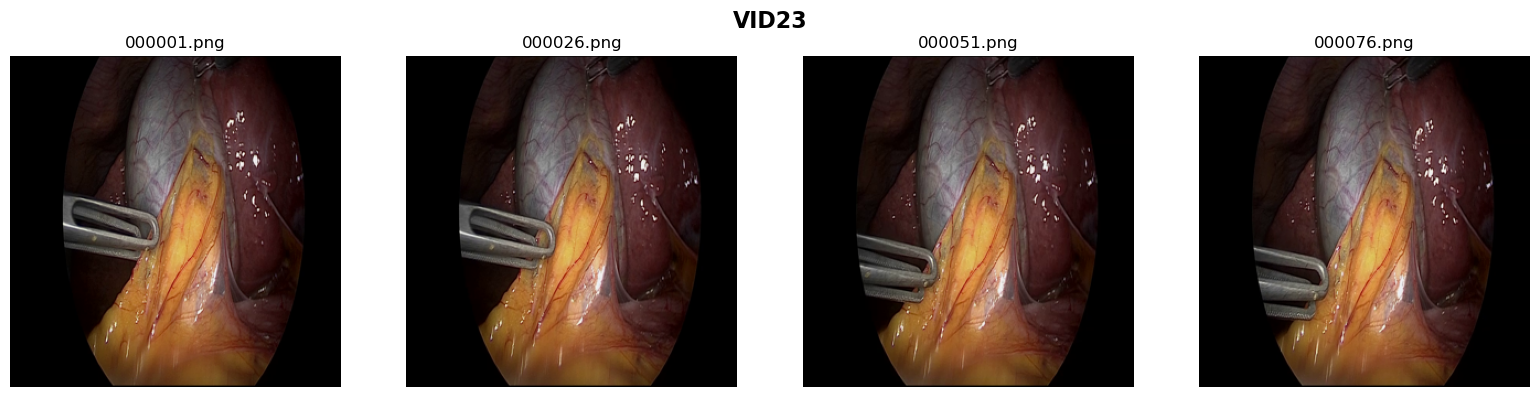

4 Frames per VID31


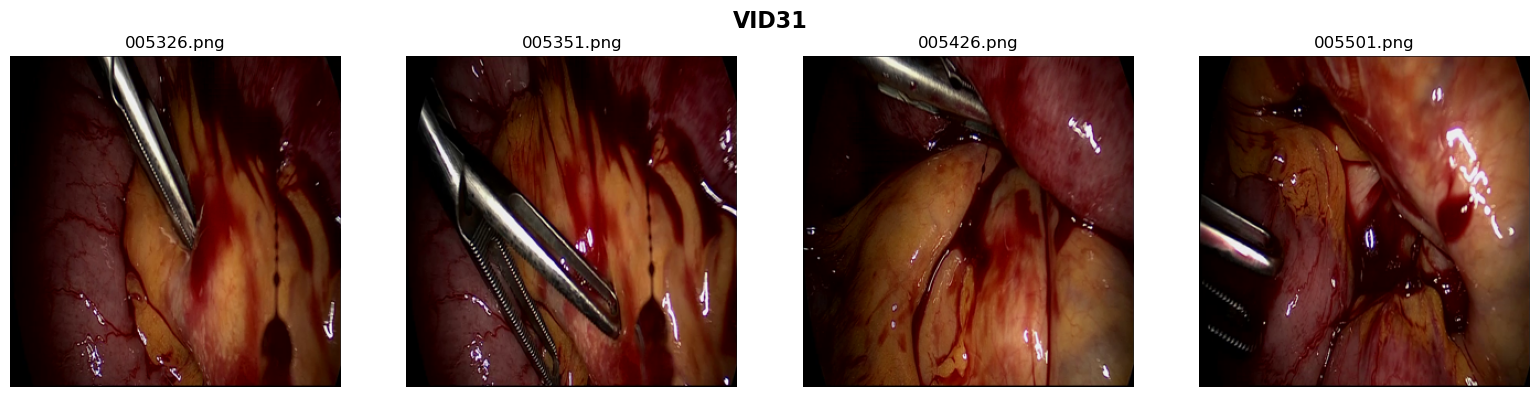

4 Frames per VID37


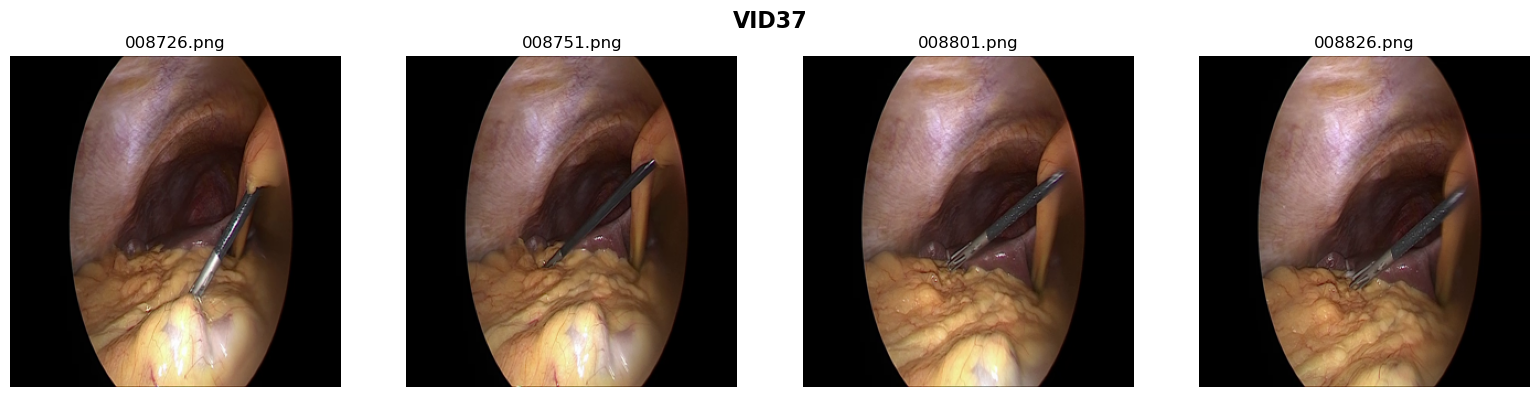

4 Frames per VID96


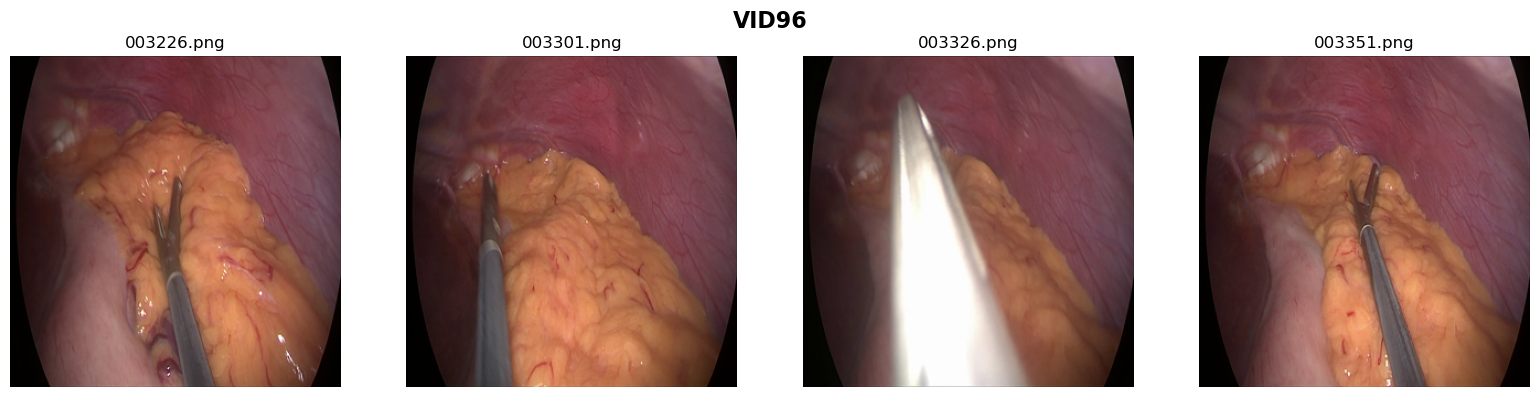

In [7]:
video_ids = [
    "VID02", "VID04", "VID103", "VID11", "VID13",
    "VID17", "VID23", "VID31", "VID37", "VID96"
]

for vid in video_ids:
    print(f"4 Frames per {vid}")
    prefix = f"Training/{vid}/Frames/"
    load_frames(prefix)


## Exploratory Data Analysis (EDA)

We check distribution of annotations, category frequency, sample frames, and dataset consistency to better understand labeling patterns.


In [8]:
# reading the json data of the frames of the sp
class read_data:
    def __init__(self, data_path):
        self.data_path = pd.read_json(prefix)
        
    def read_json_data(self, prefix):
        df = pd.read_json(prefix)
        df

    def normalizing():
        rows = []
        pd.set_option("display.max_columns", None)
        annotations = df["annotations"]
        
        for id, ann_list in annotations.items():
            if not isinstance(ann_list, list):
                continue  # skip NaN / invalid entries
        
            for ann in ann_list:
                row = ann.copy()
                row["id"] = int(id)
                rows.append(row)
        
        df_ann_flat = pd.DataFrame(rows)
        df_ann_flat.head()

In [9]:
df.shape

NameError: name 'df' is not defined

In [ ]:
df.head(10)

In [ ]:
df.info()

In [ ]:
df['annotations']

## Cleaning and Normalizing Annotation Data

Some annotation files contain nested structures. We convert them into a usable tabular format for analysis and training.


In [ ]:
"""
Step-by-step process to flatten the nested 'annotations' column.

1. Filter out rows where 'annotations' is empty or NaN.
2. Explode the column so each list item becomes a separate row.
3. Normalize each dictionary in the exploded column into individual columns.
4. Preview the structured flattened data.
"""
rows = []
pd.set_option("display.max_columns", None)
annotations = df["annotations"]

for id, ann_list in annotations.items():
    if not isinstance(ann_list, list):
        continue  # skip NaN / invalid entries

    for ann in ann_list:
        row = ann.copy()
        row["id"] = int(id)
        rows.append(row)

df_ann_flat = pd.DataFrame(rows)
df_ann_flat.head()



In [ ]:
for i in range(0,8):
    print(f"Phase number {i}: {(df_ann_flat['phase'] == i).sum()}")
"""
Phase Mapping (Derived from CholecTrack 80 and CholecT50
0 -> Preparartion
1 -> Calot Triangel dissection
2 -> Clipping and cutting
3 -> Gallbladder dissection
4 -> Gallbladder packaging
5 -> Cleaning and coagulation
6 -> Gallbladder retraction
7 -> Final inspection/ closure

Phasesku annotate karte waqt lets do 200 FPS  
"""
    

In [ ]:
df_ann_flat['id'].value_counts()

In [ ]:
df_ann_flat.shape

In [ ]:
df_ann_flat.tail()

In [ ]:

from collections import defaultdict

bucket = "surgimind01"
prefix = "Training/"

s3 = boto3.client("s3")

valid_suffixes = (".png", ".jpg", ".jpeg")
video_pattern = re.compile(r"Training/(VID\d+)/Frames/")

token = None
video_counts = defaultdict(int)

while True:
    params = {
        "Bucket": bucket,
        "Prefix": prefix,
        "MaxKeys": 1000
    }
    if token:
        params["ContinuationToken"] = token

    response = s3.list_objects_v2(**params)

    for obj in response.get("Contents", []):
        key = obj["Key"]

        if not key.lower().endswith(valid_suffixes):
            continue

        match = video_pattern.search(key)
        if match:
            video_id = match.group(1)
            video_counts[video_id] += 1

    if response.get("IsTruncated"):
        token = response["NextContinuationToken"]
    else:
        break

for video, count in sorted(video_counts.items()):
    print(f"{video} -> {count} images")



In [ ]:
from pandas import json_normalize
df_categories = df[df["categories"].notna()].copy()
df_categories = df_categories.explode("categories")
df_categories_flat = json_normalize(df_categories["categories"])
df_categories_flat


### Category Distribution
This helps us understand which instruments appear most frequently.

In [ ]:

# Count occurrences of each instrument
instrument_counts = df_ann_flat['instrument'].value_counts().sort_index()

# Display counts as a table
print(instrument_counts)

# Plot
plt.figure(figsize=(6, 4))
instrument_counts.plot(kind='bar')

plt.title("Instrument Frequency Distribution")
plt.xlabel("Instrument ID")
plt.ylabel("Count")

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## Loading Frames and Annotation Files

This step extracts image files and associated annotations. The goal is to map each frame with its corresponding metadata.


In [ ]:
bucket = "surgimind01"
prefix = "Training/VID04/Frames/"

s3 = boto3.client("s3")

valid_suffixes = (".png", ".jpg", ".jpeg")
token = None
files = []

while True:
    params = {"Bucket": bucket, "Prefix": prefix, "MaxKeys": 1000}
    if token:
        params["ContinuationToken"] = token

    response = s3.list_objects_v2(**params)

    for obj in response.get("Contents", []):
        key = obj["Key"].strip().lower()
        if key.endswith(valid_suffixes):   # only real images
            files.append(key)

    if response.get("IsTruncated"):
        token = response["NextContinuationToken"]
    else:
        break
# as it takes 0 as a starting 
print(f"Exact image count: {len(files)+1}")


In [ ]:
df = pd.read_json(r"s3://surgimind01/Training/VID04/vid04.json")

In [ ]:
df.shape

In [ ]:
"""
Step-by-step process to flatten the nested 'annotations' column.

1. Filter out rows where 'annotations' is empty or NaN.
2. Explode the column so each list item becomes a separate row.
3. Normalize each dictionary in the exploded column into individual columns.
4. Preview the structured flattened data.
"""
rows = []

annotations = df["annotations"]

for id, ann_list in annotations.items():
    if not isinstance(ann_list, list):
        continue  # skip NaN / invalid entries

    for ann in ann_list:
        row = ann.copy()
        row["id"] = int(id)
        rows.append(row)

df_ann_flat = pd.DataFrame(rows)
df_ann_flat.head()



In [ ]:
df_categories = df[df["categories"].notna()].copy()
df_categories = df_categories.explode("categories")
df_categories_flat = json_normalize(df_categories["categories"])
df_categories_flat


In [ ]:
df_ann_flat['instrument'].value_counts()

In [ ]:

# Count occurrences of each instrument
instrument_counts = df_ann_flat['instrument'].value_counts().sort_index()

# Display counts as a table
print(instrument_counts)

# Plot
plt.figure(figsize=(6, 4))
instrument_counts.plot(kind='bar')

plt.title("Instrument Frequency Distribution")
plt.xlabel("Instrument ID")
plt.ylabel("Count")

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Insights
Annotating each frame independently quickly becomes a headache.

In real video data, the same instrument appears across many consecutive frames. Frame-by-frame annotation ends up repeating the same label again and again, while small fluctuations introduce noise and reduce clarity.

To keep annotations clean, interpretable, and meaningful, we use **segmentation-based annotation**.

## Segmentation-Based Annotation

Instead of annotating every frame, we annotate **continuous segments of frames**.

A **segment** is defined as:

> A contiguous range of frames during which the `instrument_id` remains unchanged.

As long as the instrument stays the same, all frames belong to the same annotation.
When a new instrument ID appears, the current segment ends and a new annotation starts automatically.


## Why This Approach Works

* Preserves **temporal consistency**
* Avoids redundant frame-level labels
* Reduces annotation noise
* Improves clarity and debuggability
* Aligns better with event-based video understanding


## Core Principle

> Frames are timestamps.
> Instruments define events.

Segmentation keeps the data aligned with how tools actually persist over time.


## Example

**Frame-by-frame (noisy):**

```text
Frame 15 → Instrument A
Frame 16 → Instrument A
Frame 17 → Instrument A
```

**Segment-based (clean):**

```text
Instrument A → frames 15 to 17
```
## Notebook Reminder

All downstream processing (exporting, analysis, modeling) should operate on **segments**, not individual frames.

Segmentation is not an optimization.
It is the correct representation of the annotation logic.


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Aug 11 13:41:09 2022

@author: nwoye chinedu
"""

import os
import cv2
import json
import random
from matplotlib import pyplot as plt


class Visualize(object):
    def __init__(self, dataset_dir, split="Training", video="s3://surgimind01/Training/VID02/"):
        self.video_dir = os.path.join(dataset_dir, split, video)
        
        
    def get_text_on_box_position(self, text, bbox, font_scale=0.6, thickness=1):
        x, y, w, h = bbox
        text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)[0]
        if y < text_size[1]-10:
            return (int(x+(w-text_size[0])//2), int(y+h+text_size[1]+5))
        else:
            return (int(x+(w-text_size[0])//2), int(y))
        
    def list_frames(self):
        return [int(x.split(".")[0]) for x in os.listdir(os.path.join(self.video_dir, "Frames/"))]
        
    def view(self, frame_id):
        label_file = os.path.join(self.video_dir, "{}.json".format(os.path.basename(self.video_dir)))
        labels = json.load(open(label_file, "rb"))['annotations'][str(frame_id)]
        image = cv2.imread(os.path.join(self.video_dir, "Frames/{:06d}.png".format(int(frame_id))))
        image = cv2.resize(image, [854, 480])
        thickness = 1
        font_scale = 0.6
        font = cv2.FONT_HERSHEY_SIMPLEX
        names = ["Grasper", "Bipolar", "Hook", "Scissors", "Clipper", "Irrigator", "Spec.bag",]
        for label in labels:
            color = random.choice([(50,200,20), (124,114,250), (250,250,30), (250,50,250), (200,220,230),(50,250,250), (250,20,30)])
            bbox = [x*s for x,s in zip([854,480,854,480], label["tool_bbox"])]
            clsid = label["instrument"]
            intraop_track_id = label["intraoperative_track"]
            intracp_track_id = label["intracorporeal_track"]
            visio_track_id = label["visibility_track"]
            
            x, y, w, h = bbox
            cv2.rectangle(image, (int(x), int(y)), (int(x+w), int(y+h)), color, 2)
            text = "{} [{}|{}|{}]".format(names[int(clsid)], intraop_track_id, intracp_track_id, visio_track_id)
            org = self.get_text_on_box_position(text, bbox, font_scale, thickness)
            org = [x+5 for x in org]
            cv2.putText(image, text, org, font, 1.0, (255,250,255), thickness, cv2.LINE_AA)
        image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.show()
        
       
    
if __name__ == '__main__': 

    obj = Visualize("/path/to/CholecTrack20/dataset", video="VID02")
    
    # To view the frame ids
    # print(obj.list_frames())
    
    obj.view(11851)


In [ ]:
%pip install opencv-python